# Soundings data from Wyoming

- **Acquiring data with _siphon_**
    - Cases (up to two days earlier):
        - 2017-03-14
        - 2017-11-15
  
  
- **Processing data with _metpy_**
    - Generating Skew-T Log-P maps

## Loading necessary packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd

from datetime import datetime
from siphon.simplewebservice.wyoming import WyomingUpperAir

import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, Hodograph, SkewT
from metpy.units import units

## Defining dates and station for the case

In [2]:
dates = [datetime(2017, 3, 11, 0),   #-- Case 2017-03-14
         datetime(2017, 3, 11, 12),
         datetime(2017, 3, 12, 0),
         datetime(2017, 3, 12, 12),
         datetime(2017, 3, 13, 0),
         datetime(2017, 3, 13, 12),
         datetime(2017, 3, 14, 0),
         datetime(2017, 3, 14, 12),  #-- Case 2017-11-15
         datetime(2017, 11, 12, 0),
         datetime(2017, 11, 12, 12),
         datetime(2017, 11, 13, 0),
         datetime(2017, 11, 13, 12),
         datetime(2017, 11, 14, 0),
         datetime(2017, 11, 14, 12),
         datetime(2017, 11, 15, 0),
         datetime(2017, 11, 15, 12)]
station = 'SBMT'

## Acquiring data

In [3]:
soundings = []

for i in dates:
    try:
        soundings.append(WyomingUpperAir.request_data(i, station))
    except ValueError:
        pass

## First look at the data

In [4]:
soundings[0][0:5]

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation
0,934.0,722,27.0,22.0,100.0,8.0,-7.878462,1.389185,SBMT,83779,2017-03-11 12:00:00,-23.52,-46.63,722.0
1,929.0,771,25.0,20.1,114.0,7.0,-6.394818,2.847157,SBMT,83779,2017-03-11 12:00:00,-23.52,-46.63,722.0
2,925.0,810,24.6,20.0,125.0,6.0,-4.914912,3.441459,SBMT,83779,2017-03-11 12:00:00,-23.52,-46.63,722.0
3,881.0,1236,20.6,19.1,87.0,9.0,-8.987666,-0.471024,SBMT,83779,2017-03-11 12:00:00,-23.52,-46.63,722.0
4,856.0,1486,20.1,16.3,65.0,11.0,-9.969386,-4.648801,SBMT,83779,2017-03-11 12:00:00,-23.52,-46.63,722.0


## Modifying data
- Calculating u and v components
- Separating necessary variables

In [5]:
p, T, Td, u, v, date, height = ([] for i in range(7))

for item in soundings:
    item = item.dropna(subset=('pressure', 'temperature', 'dewpoint', 'u_wind', 'v_wind'), how='all')
    p.append(item['pressure'].values)
    T.append(item['temperature'].values * units.degC)
    Td.append(item['dewpoint'].values * units.degC)
    u.append(item['u_wind'].values)
    v.append(item['v_wind'].values)
    date.append(item['time'][1])
    height.append(item['height'].values)

## Creating figures

#### `pressure_interval`: defining less barbs points

In [6]:
def pressure_interval(p,u,v,upper=100,lower=1000,spacing=50):

    intervals = list(range(upper,lower,spacing))

    ix = []
    for center in intervals:
        index = (np.abs(p-center)).argmin()
        if index not in ix:
            ix.append(index)

    return p[ix],u[ix],v[ix]

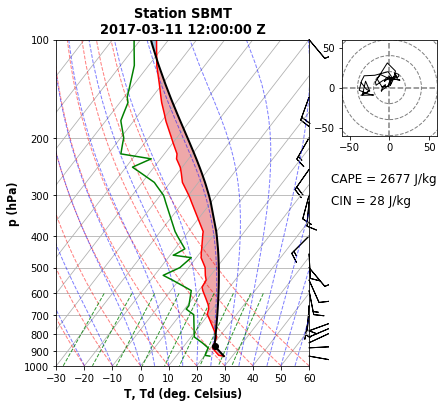

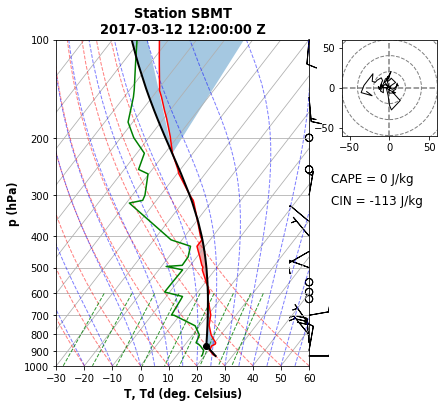

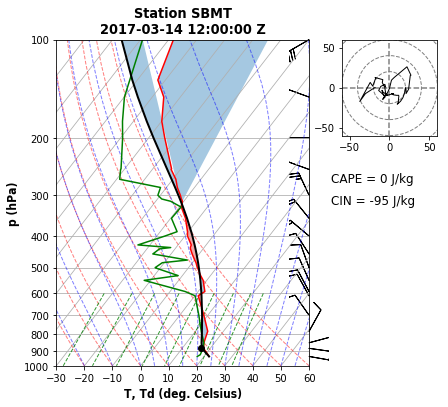

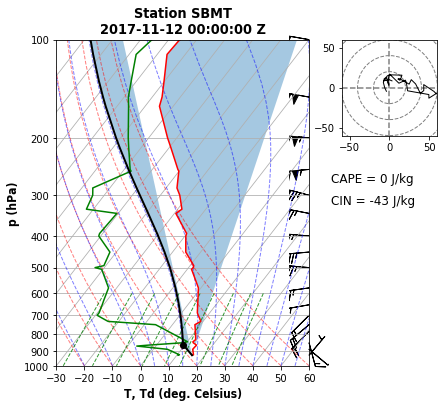

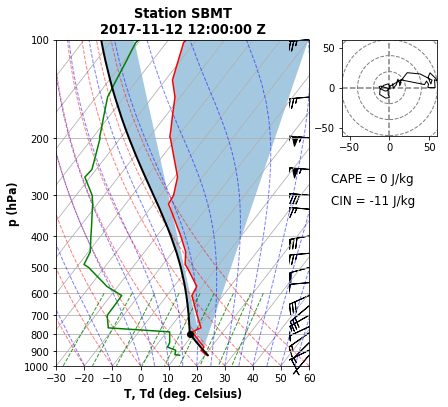

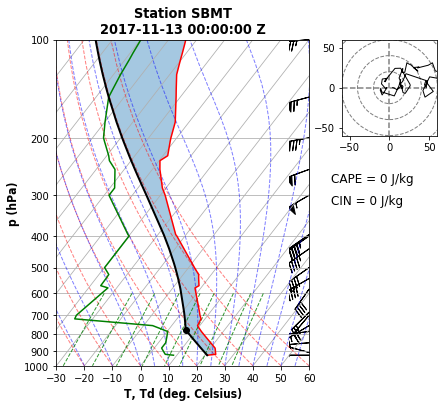

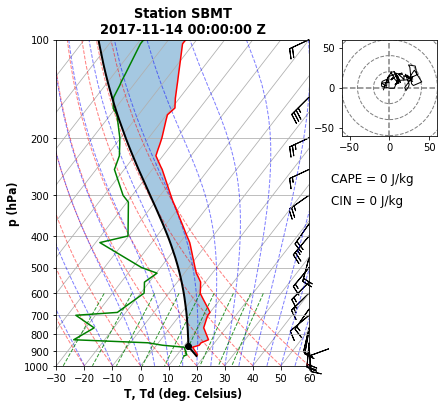

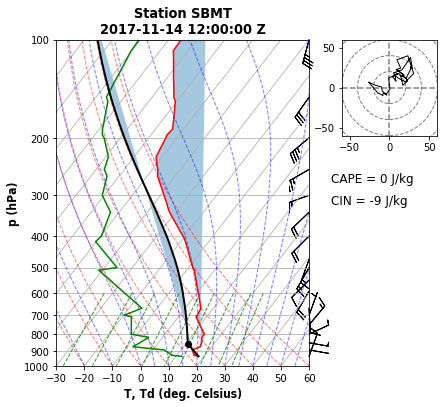

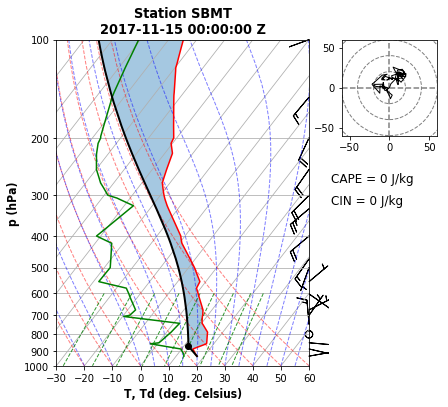

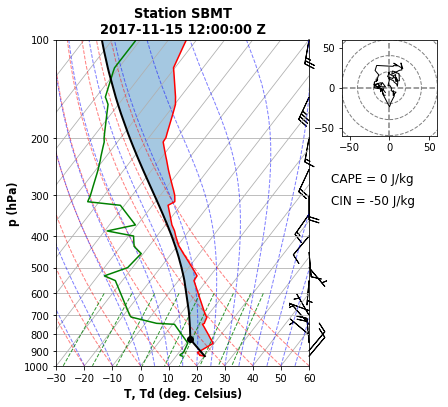

In [14]:
#-- Doing for all dates
for i in range(10):
    #-- Calculating LCL, full parcel profile, bigger interval for barbs, CAPE, CIN
    lcl_pressure, lcl_temperature = mpcalc.lcl(p[i][0] * units.hPa, T[i][0], Td[i][0])
    prof = mpcalc.parcel_profile(p[i] * units.hPa, T[i][0], Td[i][0]).to('degC')
    p_, u_, v_ = pressure_interval(p[i], u[i], v[i])
    
    cape, cin = mpcalc.cape_cin(p[i] * units.hPa, T[i], Td[i], prof)
    try: cape = str(int(round(cape * units.kilogram/units.joule)))
    except ValueError: cape = '0'
    try: cin = str(int(round(cin * units.kilogram/units.joule)))
    except ValueError: cin = '0'
    
    #-- General aspects
    fig = plt.figure(figsize=(7, 6))
    fig.set_facecolor("w")
    
    #-- Grid
    gs = gridspec.GridSpec(3, 3)
    skew = SkewT(fig, rotation=45, subplot=gs[:, :2])
    
    #-- Limits and title
    skew.ax.set_xlim(-30, 60)
    skew.ax.set_ylim(1000, 100)
    skew.ax.set_title('Station ' + station + '\n' + str(date[i]) + ' Z', 
                      weight='bold', stretch='condensed', size='x-large')
    skew.ax.set_xlabel('T, Td (deg. Celsius)', weight='bold', 
                       stretch='condensed', size='large')
    skew.ax.set_ylabel('p (hPa)', weight='bold', 
                       stretch='condensed', size='large')

    #-- Plotting data
    skew.plot(p[i], T[i], 'r')
    skew.plot(p[i], Td[i], 'g')
    
    skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor='black')
    skew.plot(p[i], prof, 'k', linewidth=2)
    
    skew.shade_cin(p[i], T[i], prof)
    skew.shade_cape(p[i], T[i], prof)
    
    skew.plot_dry_adiabats(linewidth=1)
    skew.plot_moist_adiabats(linewidth=1)
    skew.plot_mixing_lines(linewidth=1)
    
    skew.plot_barbs(p_, u_, v_, flip_barb=True)

    #-- Adding hodograph
    ax = fig.add_subplot(gs[0, -1])
    h = Hodograph(ax, component_range=60.)
    h.add_grid(increment=20)
    h.plot(u[i], v[i], linewidth=1, c='black')
    
    #-- Adding CAPE, CIN values
    ax2 = fig.add_axes([0.67, 0.5, 0.19, 0.1])
    ax2.annotate('CAPE = ' + cape + ' J/kg', xy=(0, 0.5), size='large')
    ax2.annotate('CIN = ' + cin + ' J/kg', xy=(0, 0), size='large')
    ax2.set_axis_off()
    
    #-- (Trying to) add a colorbar
    # gradient = np.linspace(0, 1, 256)
    # gradient = np.vstack((gradient, gradient))
    # ax = fig.add_axes([0.67, 0.6, 0.23, 0.01])
    # ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('viridis'))
    # ax.set_xlabel('Height (km)')
    # ax.yaxis.set_ticks([])
    # ax.xaxis.set_ticklabels(height[i]/256)
    
    #-- Saving the figures
    plt.savefig('figures/sounding_' + station + datetime.strftime(date[i], '%Y%m%d%H' +'Z.png'),
                dpi=300, bbox_inches='tight')